In [42]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import time

In [43]:
# Let's open up the CSV data files containing the run results

# Apollo with Counters
apolloWithCounters = '../counterUseFreqTests/oracle-ETE-XTimeData_PA-depth4_NO_TRACES.csv'
apolloStaticWithCounters = '../counterUseFreqTests/cntrVariab-ETE-XTimeData_PA.csv'

# this is from the './no-apollo-runs/runlogs.txt' file
noApolloData = {'nas_ft': [10.83, 10.88, 11.02, 11.01, 10.96, 10.82, 11.02, 10.93, 10.99, 11.04],
               'nas_sp': [65.12, 65.70, 65.18, 65.58, 65.30, 65.28, 65.18, 65.29, 65.23, 65.61],
               'rodinia_cfd': [10.9688, 11.0254, 10.8889, 10.9648, 10.9921, 10.9317, 10.9456, 10.876 , 11.0008, 11.0304]}

prognames = ['nas_ft', 'nas_sp', 'rodinia_cfd']

In [44]:
dynamDF = pd.read_csv(apolloWithCounters)
statiDF = pd.read_csv(apolloStaticWithCounters)

In [45]:
print(dynamDF.head(), dynamDF.shape)
print(statiDF.head(), statiDF.shape)

  progname probSize   papiCounter  cntrMode  trialnum  eteXtime
0   nas_ft  medprob  PAPI_TOT_INS  alwaysOn         3     10.99
1   nas_ft  medprob  PAPI_TOT_INS  alwaysOn         0     10.92
2   nas_ft  medprob  PAPI_TOT_INS  alwaysOn         6     11.07
3   nas_ft  medprob  PAPI_TOT_INS  alwaysOn         2     11.00
4   nas_ft  medprob  PAPI_TOT_INS  alwaysOn         5     11.12 (540, 6)
  progname probSize           policy   papiCounter    cntrMode  trialnum  \
0   nas_ft  medprob  Static,policy=0  PAPI_TOT_INS    alwaysOn         2   
1   nas_ft  medprob  Static,policy=0  PAPI_TOT_INS    alwaysOn         0   
2   nas_ft  medprob  Static,policy=0  PAPI_TOT_INS  uniqueFeat         0   
3   nas_ft  medprob  Static,policy=0  PAPI_TOT_INS    alwaysOn         1   
4   nas_ft  medprob  Static,policy=0  PAPI_TOT_INS  uniqueFeat         1   

   eteXtime  
0     10.91  
1     11.01  
2     11.02  
3     11.07  
4     10.64   (1620, 7)


In [46]:
# get the avrg xtimes for each dataset
sortCols = ['progname', 'papiCounter', 'cntrMode']

avrgDynam = dynamDF.groupby(by=sortCols).mean().reset_index().sort_values(by=sortCols)
#print(avrgDynam)

avrgStati = statiDF.groupby(by=['progname', 'papiCounter', 'cntrMode','policy']).mean().reset_index()
avrgStati = avrgStati.groupby(by=sortCols).min().reset_index()
#avrgStati = avrgStati.groupby(by=sortCols).reset_index()
avrgStati = avrgStati.sort_values(by=sortCols)
#print(avrgStati)

avrgNoApollo = pd.DataFrame(noApolloData).mean()
print(avrgNoApollo)

print(avrgDynam.shape, avrgStati.shape)

nas_ft         10.95000
nas_sp         65.34700
rodinia_cfd    10.96245
dtype: float64
(54, 5) (54, 6)


In [47]:
# now let's drop any outliers from the datasets
avrgStati = avrgStati[ ((avrgStati['progname'] == 'nas_ft') & (avrgStati['eteXtime'] < 1.25*avrgNoApollo[0]))
                     | ((avrgStati['progname'] == 'nas_sp') & (avrgStati['eteXtime'] < 1.5*avrgNoApollo[1]))
                     | ((avrgStati['progname'] == 'rodinia_cfd') & (avrgStati['eteXtime'] < 1.5*avrgNoApollo[2]))
                     ]

avrgDynam = avrgDynam[ ((avrgDynam['progname'] == 'nas_ft') & (avrgDynam['eteXtime'] < 1.25*avrgNoApollo[0]))
                     | ((avrgDynam['progname'] == 'nas_sp') & (avrgDynam['eteXtime'] < 1.5*avrgNoApollo[1]))
                     | ((avrgDynam['progname'] == 'rodinia_cfd') & (avrgDynam['eteXtime'] < 1.5*avrgNoApollo[2]))
                     ]

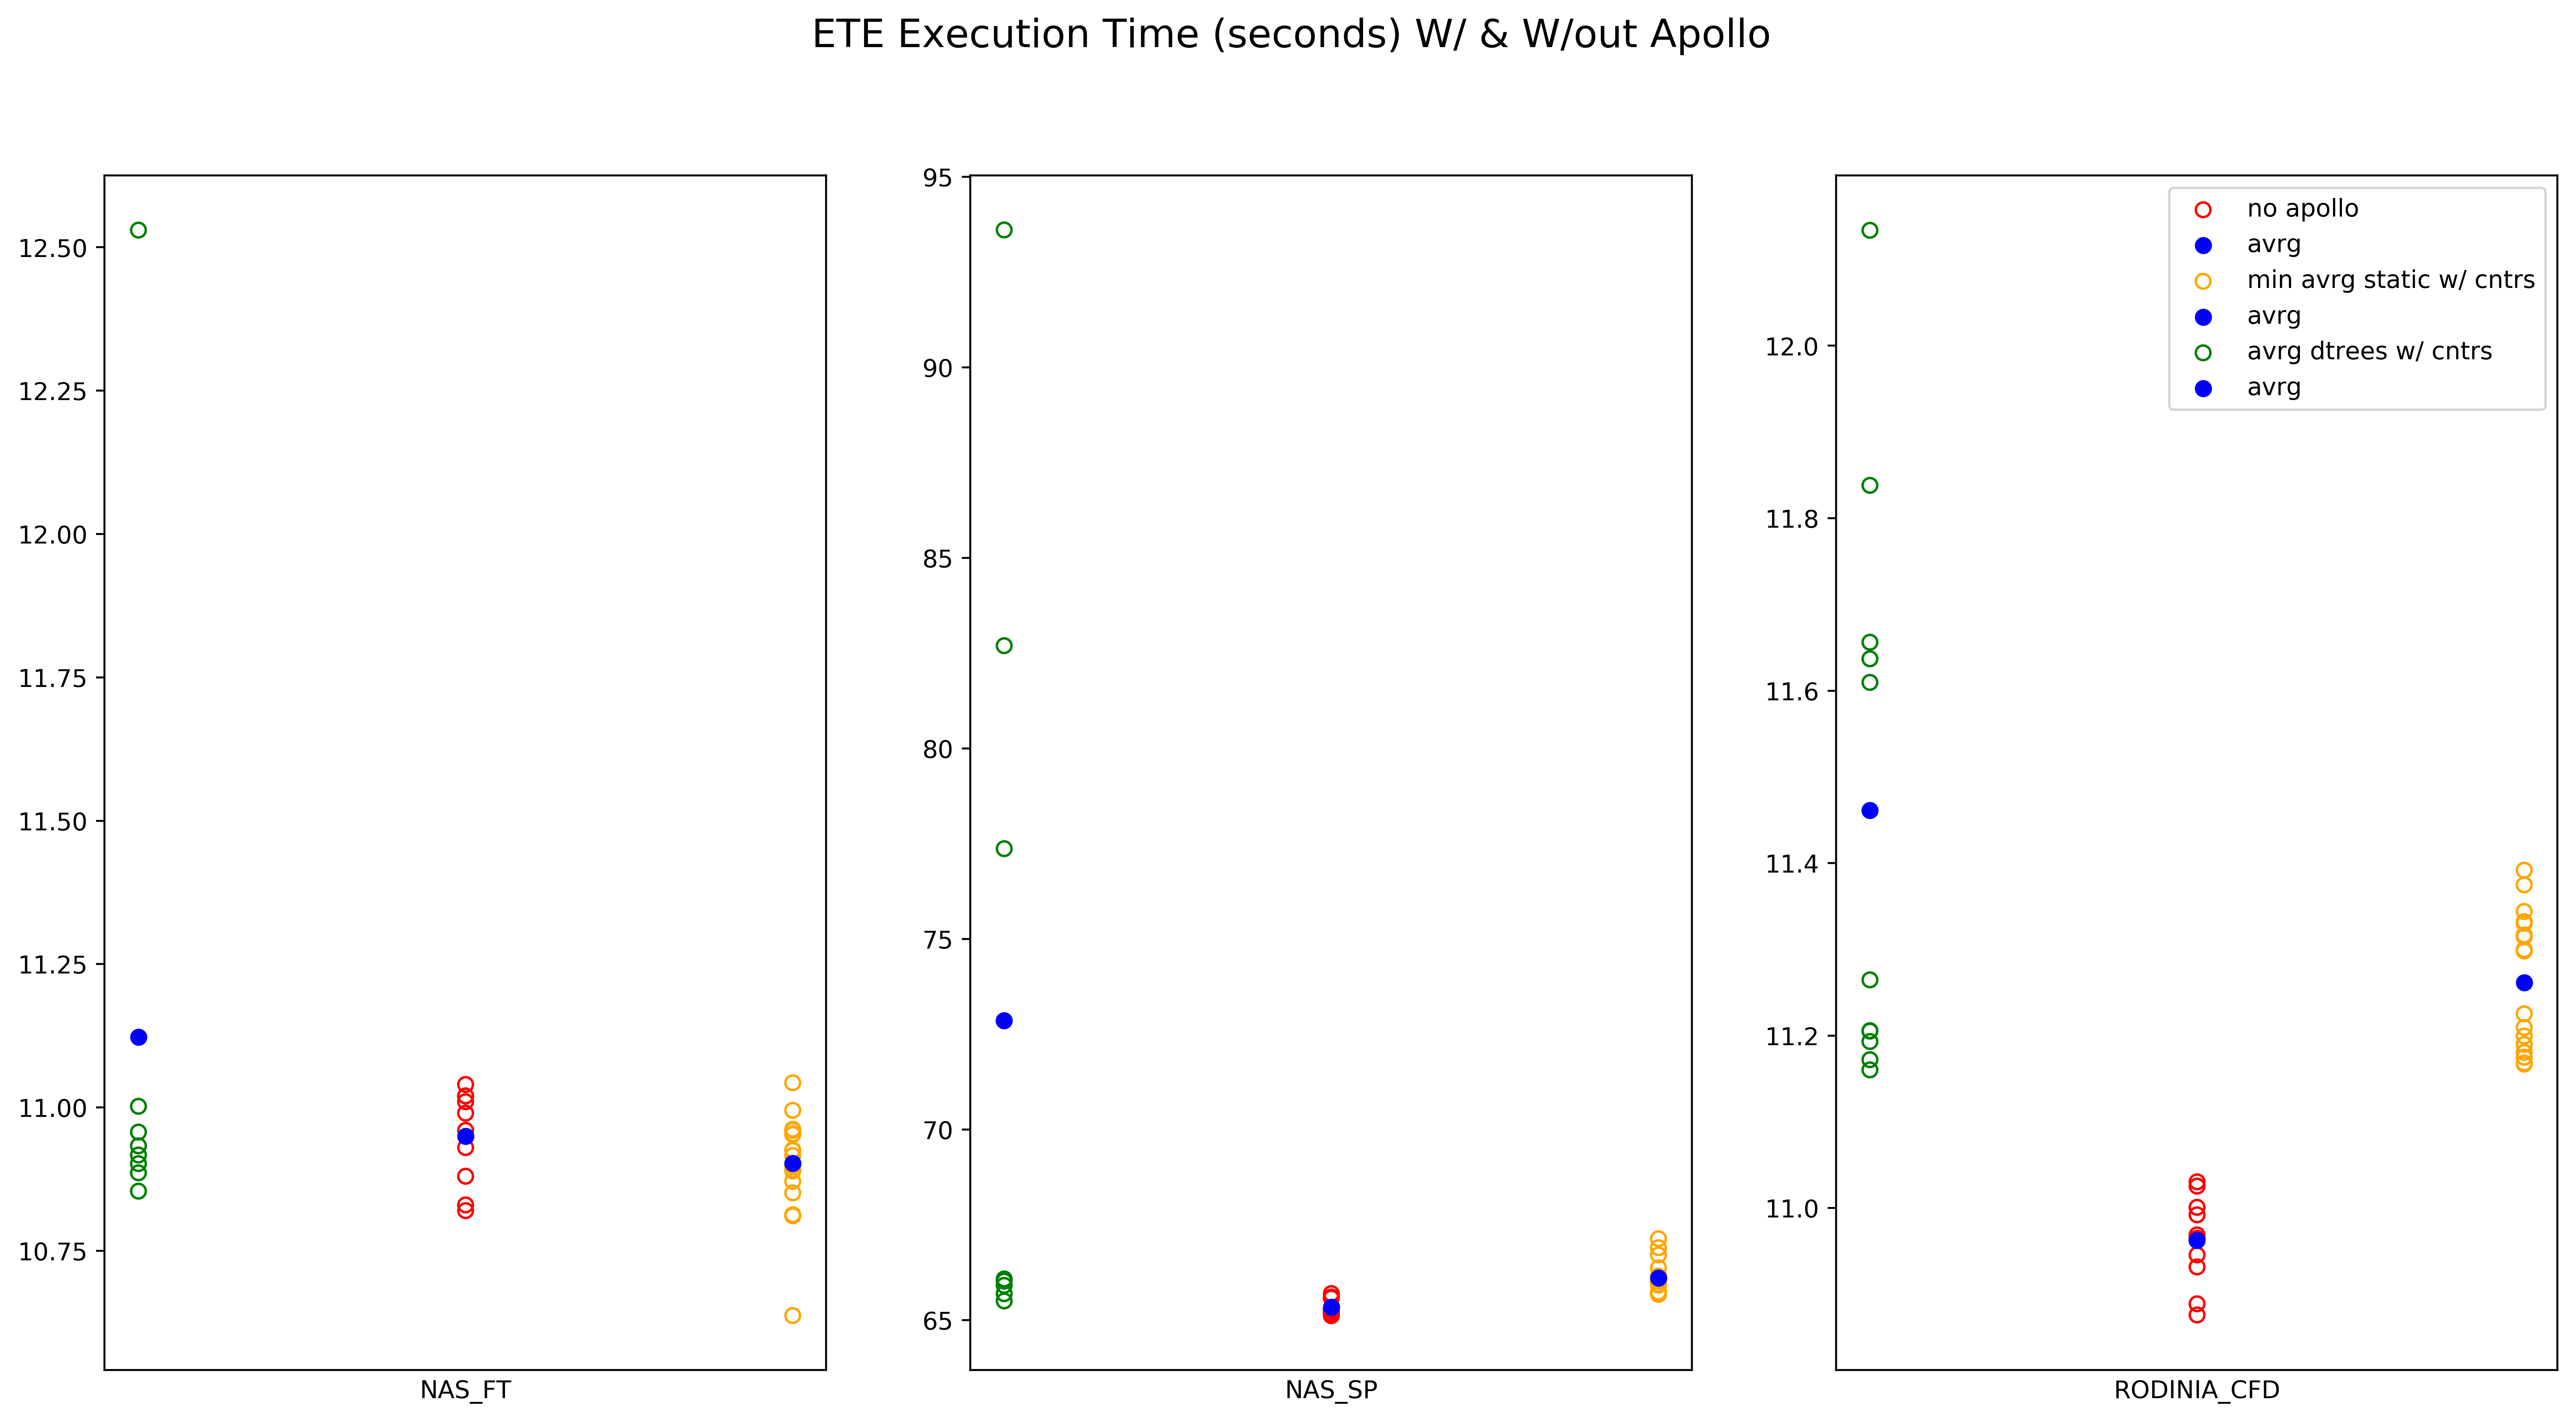

In [48]:
# let's compare the three types of runs

fig, axs = plt.subplots(1,3)
fig.set_size_inches(18, 9)
fig.set_dpi(500)

ax0 = axs[0]
ax1 = axs[1]
ax2 = axs[2]


# let's plot the baseline averages
ax0.scatter(x=[0]*10, y=noApolloData['nas_ft'], marker='o', label='no apollo', color='red', facecolors='none')
ax0.scatter(x=0, y=avrgNoApollo[0], marker='o', label='avrg', color='blue')

ax1.scatter(x=[0]*10, y=noApolloData['nas_sp'], marker='o', label='no apollo', color='red', facecolors='none')
ax1.scatter(x=0, y=avrgNoApollo[1], marker='o', label='avrg', color='blue')

ax2.scatter(x=[0]*10, y=noApolloData['rodinia_cfd'], marker='o', label='no apollo', color='red', facecolors='none')
ax2.scatter(x=0, y=avrgNoApollo[2], marker='o', label='avrg', color='blue')


nas_ft_data = avrgStati[avrgStati['progname'] == 'nas_ft']
ax0.scatter(x=[0.5]*nas_ft_data.shape[0], y=nas_ft_data['eteXtime'], label='min avrg static w/ cntrs', color='orange', facecolors='none')
ax0.scatter(x=0.5, y=np.mean(nas_ft_data['eteXtime']), marker='o', label='avrg', color='blue')
nas_ft_data = avrgDynam[avrgDynam['progname'] == 'nas_ft']
ax0.scatter(x=[-0.5]*nas_ft_data.shape[0], y=nas_ft_data['eteXtime'], label='avrg dtrees w/ cntrs', color='green', facecolors='none')
ax0.scatter(x=-0.5, y=np.mean(nas_ft_data['eteXtime']), marker='o', label='avrg', color='blue')

nas_sp_data = avrgStati[avrgStati['progname'] == 'nas_sp']
ax1.scatter(x=[0.5]*nas_sp_data.shape[0], y=nas_sp_data['eteXtime'], label='min avrg static w/ cntrs', color='orange', facecolors='none')
ax1.scatter(x=0.5, y=np.mean(nas_sp_data['eteXtime']), marker='o', label='avrg', color='blue')
nas_sp_data = avrgDynam[avrgDynam['progname'] == 'nas_sp']
ax1.scatter(x=[-0.5]*nas_sp_data.shape[0], y=nas_sp_data['eteXtime'], label='avrg dtrees w/ cntrs', color='green', facecolors='none')
ax1.scatter(x=-0.5, y=np.mean(nas_sp_data['eteXtime']), marker='o', label='avrg', color='blue')


cfd_data = avrgStati[avrgStati['progname'] == 'rodinia_cfd']
ax2.scatter(x=[0.5]*cfd_data.shape[0], y=cfd_data['eteXtime'], label='min avrg static w/ cntrs', color='orange', facecolors='none')
ax2.scatter(x=0.5, y=np.mean(cfd_data['eteXtime']), marker='o', label='avrg', color='blue')
cfd_data = avrgDynam[avrgDynam['progname'] == 'rodinia_cfd']
ax2.scatter(x=[-0.5]*cfd_data.shape[0], y=cfd_data['eteXtime'], label='avrg dtrees w/ cntrs', color='green', facecolors='none')
ax2.scatter(x=-0.5, y=np.mean(cfd_data['eteXtime']), marker='o', label='avrg', color='blue')

ax0.get_xaxis().set_ticks([])
ax1.get_xaxis().set_ticks([])
ax2.get_xaxis().set_ticks([])


# how much do the apollo runs differ from the no-apollo runs
#ax0.set_title('No Apollo vs Apollo')
#ax.set_yticks(list(region_map.values()))
#ax1.set_yticklabels(list(region_map.keys()))
ax0.set_xlabel('NAS_FT')
ax1.set_xlabel('NAS_SP')
ax2.set_xlabel('RODINIA_CFD')



fig.suptitle('ETE Execution Time (seconds) W/ & W/out Apollo', fontsize=16)
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.15))
plt.legend()
plt.show()

In [11]:
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/ep-data'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/cg-data'
trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/rodinia/rodinia_3.1/openmp/cfd/cfd-data'
#trialsDir = '/g/g15/bolet1/workspace/faros/FAROS/bin/Quicksilver/omp/qs-data'
#trialsDir = '/g/g15/bolet1/workspace/faros/FAROS/bin/XSBench/omp/xsbench-data'
#trialsDir = '/g/g15/bolet1/workspace/faros/FAROS/bin/miniFE/omp/minife-data'
#trialsDir = '/g/g15/bolet1/workspace/faros/FAROS/bin/CoMD/omp/comd-data'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/rodinia/rodinia_3.1/openmp/heartwall/heartwall-data'
#trialsDir = '/g/g15/bolet1/workspace/lulesh-region-fix-correct/LULESH/build/lulesh-data/'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/lu-data'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/ft-data'


problemSize = 'medprob'
pava = 'VA'
trialsToUse=[0,1,2,3]

In [12]:
%%time
# let's open all the CSV files in the given directory
csvs = []
for trial in trialsToUse:
    csvs = csvs + list(glob.glob(trialsDir+'/'+'*-'+problemSize+'*-trial'+str(trial)+'*-'+pava+'-traces/*.csv'))
    
print('Reading CSVs:\n', '\n'.join([os.path.basename(x) for x in csvs]))

df = pd.DataFrame()
for idx, csv in enumerate(csvs):
    print(csv, 'reading csv', idx+1, 'of', len(csvs), end='')
    starttime = time.time()
    rawdf = pd.read_csv(csv, sep=' ')
    df = df.append(rawdf)
    print(' -- Read in', time.time()-starttime, 'seconds')

Reading CSVs:
 trace-Static,policy=0-region-exact_rhs.c.apollo.region.l45-rank-0.csv
trace-Static,policy=0-region-initialize.c.apollo.region.l46-rank-0.csv
trace-Static,policy=0-region-rhs.c.apollo.region.l44-rank-0.csv
trace-Static,policy=0-region-txinvr.c.apollo.region.l46-rank-0.csv
trace-Static,policy=0-region-x_solve.c.apollo.region.l49-rank-0.csv
trace-Static,policy=0-region-ninvr.c.apollo.region.l46-rank-0.csv
trace-Static,policy=0-region-y_solve.c.apollo.region.l49-rank-0.csv
trace-Static,policy=0-region-pinvr.c.apollo.region.l46-rank-0.csv
trace-Static,policy=0-region-z_solve.c.apollo.region.l53-rank-0.csv
trace-Static,policy=0-region-tzetar.c.apollo.region.l47-rank-0.csv
trace-Static,policy=0-region-add.c.apollo.region.l45-rank-0.csv
trace-Static,policy=0-region-error.c.apollo.region.l52-rank-0.csv
trace-Static,policy=0-region-error.c.apollo.region.l99-rank-0.csv
trace-Static,policy=1-region-exact_rhs.c.apollo.region.l45-rank-0.csv
trace-Static,policy=1-region-initialize.c.ap

/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


0.010416507720947266 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial0-VA-traces/trace-Static,policy=1-region-exact_rhs.c.apollo.region.l45-rank-0.csv reading csv 14 of 156 -- Read in 0.011908769607543945 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial0-VA-traces/trace-Static,policy=1-region-initialize.c.apollo.region.l46-rank-0.csv reading csv 15 of 156 -- Read in 0.012641668319702148 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial0-VA-traces/trace-Static,policy=1-region-rhs.c.apollo.region.l44-rank-0.csv reading csv 16 of 156 -- Read in 0.024466991424560547 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial0-VA-traces/trace-Static,policy=1-region-txinvr.c.apollo.region.l46-rank-0.csv reading csv 17 of 156 -- Read in 0.011981725692749023 seconds
/g/g15/bolet1/workspace/benchma

/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial1-VA-traces/trace-Static,policy=0-region-tzetar.c.apollo.region.l47-rank-0.csv reading csv 49 of 156 -- Read in 0.032449960708618164 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial1-VA-traces/trace-Static,policy=0-region-add.c.apollo.region.l45-rank-0.csv reading csv 50 of 156 -- Read in 0.0381474494934082 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial1-VA-traces/trace-Static,policy=0-region-error.c.apollo.region.l52-rank-0.csv reading csv 51 of 156 -- Read in 0.03849911689758301 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial1-VA-traces/trace-Static,policy=0-region-error.c.apollo.region.l99-rank-0.csv reading csv 52 of 156 -- Read in 0.010733604431152344 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-

/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial2-VA-traces/trace-Static,policy=0-region-y_solve.c.apollo.region.l49-rank-0.csv reading csv 85 of 156 -- Read in 0.019974231719970703 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial2-VA-traces/trace-Static,policy=0-region-pinvr.c.apollo.region.l46-rank-0.csv reading csv 86 of 156 -- Read in 0.028642654418945312 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial2-VA-traces/trace-Static,policy=0-region-z_solve.c.apollo.region.l53-rank-0.csv reading csv 87 of 156 -- Read in 0.03962230682373047 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial2-VA-traces/trace-Static,policy=0-region-tzetar.c.apollo.region.l47-rank-0.csv reading csv 88 of 156 -- Read in 0.02028799057006836 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/

/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial3-VA-traces/trace-Static,policy=0-region-z_solve.c.apollo.region.l53-rank-0.csv reading csv 126 of 156 -- Read in 0.02503228187561035 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial3-VA-traces/trace-Static,policy=0-region-tzetar.c.apollo.region.l47-rank-0.csv reading csv 127 of 156 -- Read in 0.03515911102294922 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial3-VA-traces/trace-Static,policy=0-region-add.c.apollo.region.l45-rank-0.csv reading csv 128 of 156 -- Read in 0.04463386535644531 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data/sp-medprob-trial3-VA-traces/trace-Static,policy=0-region-error.c.apollo.region.l52-rank-0.csv reading csv 129 of 156 -- Read in 0.01319575309753418 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bi

In [13]:
%%time

# let's only keep a few columns
df = df[['region', 'globalidx', 'policy', 'xtime']]
df = df.reset_index(drop=True)

# average out the xtimes for each trial
if len(trialsToUse) > 1:
    df = df.groupby(['region', 'globalidx', 'policy'])['xtime'].mean().reset_index().sort_values(by=['globalidx'])   

CPU times: user 24 ms, sys: 9 µs, total: 24 ms
Wall time: 21.5 ms


In [14]:
%%time
# sanity check the shape
print(df.shape)
print(df.columns)

# if we're working with lulesh data, let's plot the beginning data
#luleshdf = df.loc[(df['globalidx'] <= 15000) & (df['globalidx'] >= 10000)]

(10845, 4)
Index(['region', 'globalidx', 'policy', 'xtime'], dtype='object')
CPU times: user 394 µs, sys: 0 ns, total: 394 µs
Wall time: 370 µs


In [15]:
def plotAllPolicies(df, policiesToPlot=[0,1,2]):
    df = df.loc[[ (x in policiesToPlot) for x in df['policy']]]
    
    grouped = df.groupby(['region', 'globalidx'])
    maxs = df.loc[grouped['xtime'].idxmax()]
    toplot = maxs.sort_values(by=['globalidx']).reset_index(drop=True)
    #toplot = maxs.copy()

    # We will also count the number of unique regions, discrtize, and map them to integers
    regions = list(toplot['region'].unique())
    num_regions = len(regions)

    region_map = dict(zip(regions, range(num_regions)))

    # set the starting point of all the groups of policies
    toplot['x_start'] = toplot['xtime'].cumsum().shift(fill_value=0)

    toplot.drop('policy', axis=1, inplace=True)
    toplot.drop('xtime', axis=1, inplace=True)
    
    #now let's add the endpoint columns
    for pol in policiesToPlot:
        toplot['x_end'+str(pol)] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == pol].sort_values(by=['globalidx'])['xtime'].to_numpy()
    
    #toplot['x_end0'] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == 0].sort_values(by=['globalidx'])['xtime'].to_numpy()
    #toplot['x_end1'] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == 1].sort_values(by=['globalidx'])['xtime'].to_numpy()
    #toplot['x_end2'] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == 2].sort_values(by=['globalidx'])['xtime'].to_numpy()
    
    # make the y-axis values for each datapoint
    toplot['y'] = toplot.apply(lambda row: region_map[row.region], axis=1)
    
    # Now that we have the necessary columns, let's plot ALL the policies
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(18, 10)
    fig1.set_dpi(500)

    offset=0.1
    
    polData = [
               ('x_end0', offset, 'red', 'policy0'),
               ('x_end1', 0, 'green', 'policy1'),
               ('x_end2', -offset, 'blue', 'policy2')
              ]

    for index, row in toplot.iterrows():
        for pol in policiesToPlot:
            ax1.plot([row.x_start, row[polData[pol][0]]], [row.y+polData[pol][1], row.y+polData[pol][1]], color=polData[pol][2],   label=polData[pol][3], marker='o', markersize=4)
        #ax1.plot([row.x_start, row.x_end0], [row.y+offset, row.y+offset], color='red',   label='policy0', marker='o', markersize=4)
        #ax1.plot([row.x_start, row.x_end1], [row.y,        row.y       ], color='green', label='policy1', marker='o', markersize=4)
        #ax1.plot([row.x_start, row.x_end2], [row.y-offset, row.y-offset], color='blue',  label='policy2', marker='o', markersize=4)
        if (index % 1000) == 0:
            print('current index: ', index, '(', 100*(index+1)/toplot.shape[0] ,')')

    print(region_map.keys())

    ax1.set_title(trialsDir+' -- '+problemSize+' averaged over static '+pava+' trials:'+str(trialsToUse))
    #ax1.set_yticklabels(regions)
    ax1.set_yticks(list(region_map.values()))
    ax1.set_yticklabels(list(region_map.keys()))
    ax1.set_xlabel('Execution Time (seconds)')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.15))
    plt.show()
    return

def getOptimalPolicy(df):
    grouped = df.groupby(['region', 'globalidx'])
    mins = df.loc[grouped['xtime'].idxmin()]
    toplot = mins.sort_values(by=['globalidx']).reset_index(drop=True)
    
    #print(toplot)
    print('Optimal xtime:', toplot['xtime'].sum())
    print('Policy 0 xtime:', df.loc[df['policy'] == 0]['xtime'].sum())
    print('Policy 1 xtime:', df.loc[df['policy'] == 1]['xtime'].sum())
    print('Policy 2 xtime:', df.loc[df['policy'] == 2]['xtime'].sum())
    print(df.shape)
    print(df.columns)
    
    return toplot

def plotOptimalPolicy(df, policiesToPlot=[0,1,2]):
    df = df.loc[[ (x in policiesToPlot) for x in df['policy']]]
    
    grouped = df.groupby(['region', 'globalidx'])
    mins = df.loc[grouped['xtime'].idxmin()]
    toplot = mins.sort_values(by=['globalidx']).reset_index(drop=True)
    #toplot = mins.copy()
    
    # We will also count the number of unique regions, discrtize, and map them to integers
    regions = list(toplot['region'].unique())
    num_regions = len(regions)

    region_map = dict(zip(regions, range(num_regions)))

    # set the starting point of all the groups of policies
    toplot['x_end'] = toplot['xtime'].cumsum()
    toplot['x_start'] = toplot['x_end'].shift(fill_value=0)

    #toplot.drop('policy', axis=1, inplace=True)
    toplot.drop('xtime', axis=1, inplace=True)
    
    # make the y-axis values for each datapoint
    toplot['y'] = toplot.apply(lambda row: region_map[row.region], axis=1)
    
    policyColors = ['red', 'green', 'blue']
    
    # Now that we have the necessary columns, let's plot ALL the policies
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(18, 10)
    fig1.set_dpi(500)

    for index, row in toplot.iterrows():
        ax1.plot([row.x_start, row.x_end], [row.y, row.y], color=policyColors[row.policy],   label='policy'+str(row.policy), marker='o', markersize=4)
        if (index % 1000) == 0:
            print('current index: ', index, '(', 100*(index+1)/toplot.shape[0] ,')')

    print(region_map.keys())
    print('optimal xtime is:', toplot['x_end'].max(), 'seconds')

    ax1.set_title(trialsDir+' -- '+problemSize+' averaged over static '+pava+' trials:'+str(trialsToUse))
    #ax1.set_yticklabels(regions)
    ax1.set_yticks(list(region_map.values()))
    ax1.set_yticklabels(list(region_map.keys()))
    ax1.set_xlabel('Execution Time (seconds)')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.15))
    plt.show()
    
    

    return
    

In [16]:
optimPolicy = getOptimalPolicy(df)
print(optimPolicy)

Optimal xtime: 66.77895219
Policy 0 xtime: 66.8438015525
Policy 1 xtime: 114.46459845
Policy 2 xtime: 609.02100035
(10845, 4)
Index(['region', 'globalidx', 'policy', 'xtime'], dtype='object')
                              region  globalidx  policy     xtime
0      exact_rhs.c.apollo.region.l45          0       1  0.143931
1     initialize.c.apollo.region.l46          1       0  0.037767
2            rhs.c.apollo.region.l44          2       0  0.072441
3         txinvr.c.apollo.region.l46          3       0  0.005168
4        x_solve.c.apollo.region.l49          4       1  0.051070
5          ninvr.c.apollo.region.l46          5       0  0.003061
6        y_solve.c.apollo.region.l49          6       0  0.051010
7          pinvr.c.apollo.region.l46          7       0  0.003238
8        z_solve.c.apollo.region.l53          8       1  0.053731
9         tzetar.c.apollo.region.l47          9       0  0.006564
10           add.c.apollo.region.l45         10       0  0.004343
11    initialize

In [19]:
# now let's go through each of the oracle trials

modes=['uniqueFeat', 'alwaysOn']
counters=[
'PAPI_TOT_INS', 'PAPI_DP_OPS', 
'PAPI_SP_OPS', 'PAPI_LD_INS', 
'PAPI_SR_INS', 'PAPI_LST_INS', 
'PAPI_BR_INS', 'PAPI_L3_LDM', 
'PAPI_RES_STL' 
]

oracleCntrPolicies = {}

# let's open all the CSV files in the given directory
for cntr in counters:
    for mode in modes:
        csvs = []
        for trial in trialsToUse:
            csvs = csvs + list(glob.glob(trialsDir+'/'+'*-'+problemSize+'-'+cntr+'-'+mode+'-usingOracle-oracle-'+'trial'+str(trial)+'*-PA'+'-traces/*.csv'))

        # now lets read in the csvs into a dataframe
        #print('Reading CSVs:\n', '\n'.join([os.path.basename(x) for x in csvs]))

        # gather all the data
        locdf = pd.DataFrame()
        for idx, csv in enumerate(csvs):
            #print(csv, 'reading csv', idx+1, 'of', len(csvs), end='')
            starttime = time.time()
            rawdf = pd.read_csv(csv, sep=' ')
            locdf = locdf.append(rawdf)
            #print(' -- Read in', time.time()-starttime, 'seconds')
        
        # this data was captured using the oracle d-trees, so we assume these are optimal
        # policies that are being selected, 
        # let's only keep a few columns
        locdf = locdf[['region', 'globalidx', 'policy', 'xtime']]
        locdf = locdf.reset_index(drop=True)

        # average out the xtimes for each trial
        if len(trialsToUse) > 1:
            locdf = locdf.groupby(['region', 'globalidx', 'policy'])['xtime'].mean().reset_index().sort_values(by=['globalidx'])  
        
        # let's take the mode across trials
        # some modes might have ties, so we'll see some policy distributions as being either-or
        policy = locdf.groupby(['globalidx'])['policy'].agg(pd.Series.mode).reset_index()
        #print('mode-based policy:', policy)
        print(cntr, mode, 'policy distrib:\n', policy['policy'].value_counts())
        print()
        oracleCntrPolicies[(cntr, mode)] = policy.copy()
        


PAPI_TOT_INS uniqueFeat policy distrib:
 0    3615
Name: policy, dtype: int64

PAPI_TOT_INS alwaysOn policy distrib:
 2    2414
0    1201
Name: policy, dtype: int64

PAPI_DP_OPS uniqueFeat policy distrib:
 0    3615
Name: policy, dtype: int64

PAPI_DP_OPS alwaysOn policy distrib:
 0    3615
Name: policy, dtype: int64

PAPI_SP_OPS uniqueFeat policy distrib:
 0    3615
Name: policy, dtype: int64

PAPI_SP_OPS alwaysOn policy distrib:
 0    3615
Name: policy, dtype: int64

PAPI_LD_INS uniqueFeat policy distrib:
 2    3615
Name: policy, dtype: int64

PAPI_LD_INS alwaysOn policy distrib:
 2         2014
0          400
[1, 2]       1
[0, 1]       1
[0, 1]       1
[0, 2]       1
[1, 2]       1
[1, 2]       1
[1, 2]       1
[0, 1]       1
[0, 2]       1
[0, 1]       1
[1, 2]       1
[1, 2]       1
[1, 2]       1
[0, 1]       1
[0, 2]       1
[0, 2]       1
[1, 2]       1
[0, 1]       1
[1, 2]       1
[0, 2]       1
[1, 2]       1
[1, 2]       1
[0, 1]       1
[0, 2]       1
[1, 2]       1
[0, 2

In [20]:
# now that we have the optimal policies and the oracle-based policies
# let's calculate their classification scores
for cntr in counters:
    for mode in modes:
        policy = oracleCntrPolicies[(cntr, mode)]
        # compare this policy to the optimal
        truth = optimPolicy.sort_values(by=['globalidx'])['policy']
        toTest = policy.sort_values(by=['globalidx'])['policy']
        
        # take the diffs between the columns, if a diff is 0, then they match, nonzero they mismatch
        diff = truth - toTest
        #print(diff)
        totalIdxs = len(truth.index)
        try:
            totalMispred = diff.astype(bool).sum(axis=0)
            print('[%16s %12s] Mispredicted: %5d/%5d=%.3f'%(cntr, mode, totalMispred, totalIdxs, float(totalMispred)/totalIdxs))
        except:
            print('[%16s %12s] skipping...'%(cntr, mode))
            

[    PAPI_TOT_INS   uniqueFeat] Mispredicted:    30/ 3615=0.008
[    PAPI_TOT_INS     alwaysOn] Mispredicted:  2437/ 3615=0.674
[     PAPI_DP_OPS   uniqueFeat] Mispredicted:    30/ 3615=0.008
[     PAPI_DP_OPS     alwaysOn] Mispredicted:    30/ 3615=0.008
[     PAPI_SP_OPS   uniqueFeat] Mispredicted:    30/ 3615=0.008
[     PAPI_SP_OPS     alwaysOn] Mispredicted:    30/ 3615=0.008
[     PAPI_LD_INS   uniqueFeat] Mispredicted:  3615/ 3615=1.000
[     PAPI_LD_INS     alwaysOn] skipping...
[     PAPI_SR_INS   uniqueFeat] Mispredicted:  3608/ 3615=0.998
[     PAPI_SR_INS     alwaysOn] Mispredicted:   439/ 3615=0.121
[    PAPI_LST_INS   uniqueFeat] Mispredicted:  3615/ 3615=1.000
[    PAPI_LST_INS     alwaysOn] skipping...
[     PAPI_BR_INS   uniqueFeat] Mispredicted:  1184/ 3615=0.328
[     PAPI_BR_INS     alwaysOn] skipping...
[     PAPI_L3_LDM   uniqueFeat] Mispredicted:  2438/ 3615=0.674
[     PAPI_L3_LDM     alwaysOn] skipping...
[    PAPI_RES_STL   uniqueFeat] Mispredicted:   431/ 361

current index:  0 ( 0.9009009009009009 )
dict_keys(['ft.c.apollo.region.l199', 'ft.c.apollo.region.l376', 'ft.c.apollo.region.l263', 'ft.c.apollo.region.l447', 'ft.c.apollo.region.l480', 'ft.c.apollo.region.l513', 'ft.c.apollo.region.l223', 'ft.c.apollo.region.l676'])
optimal xtime is: 11.083384385250003 seconds


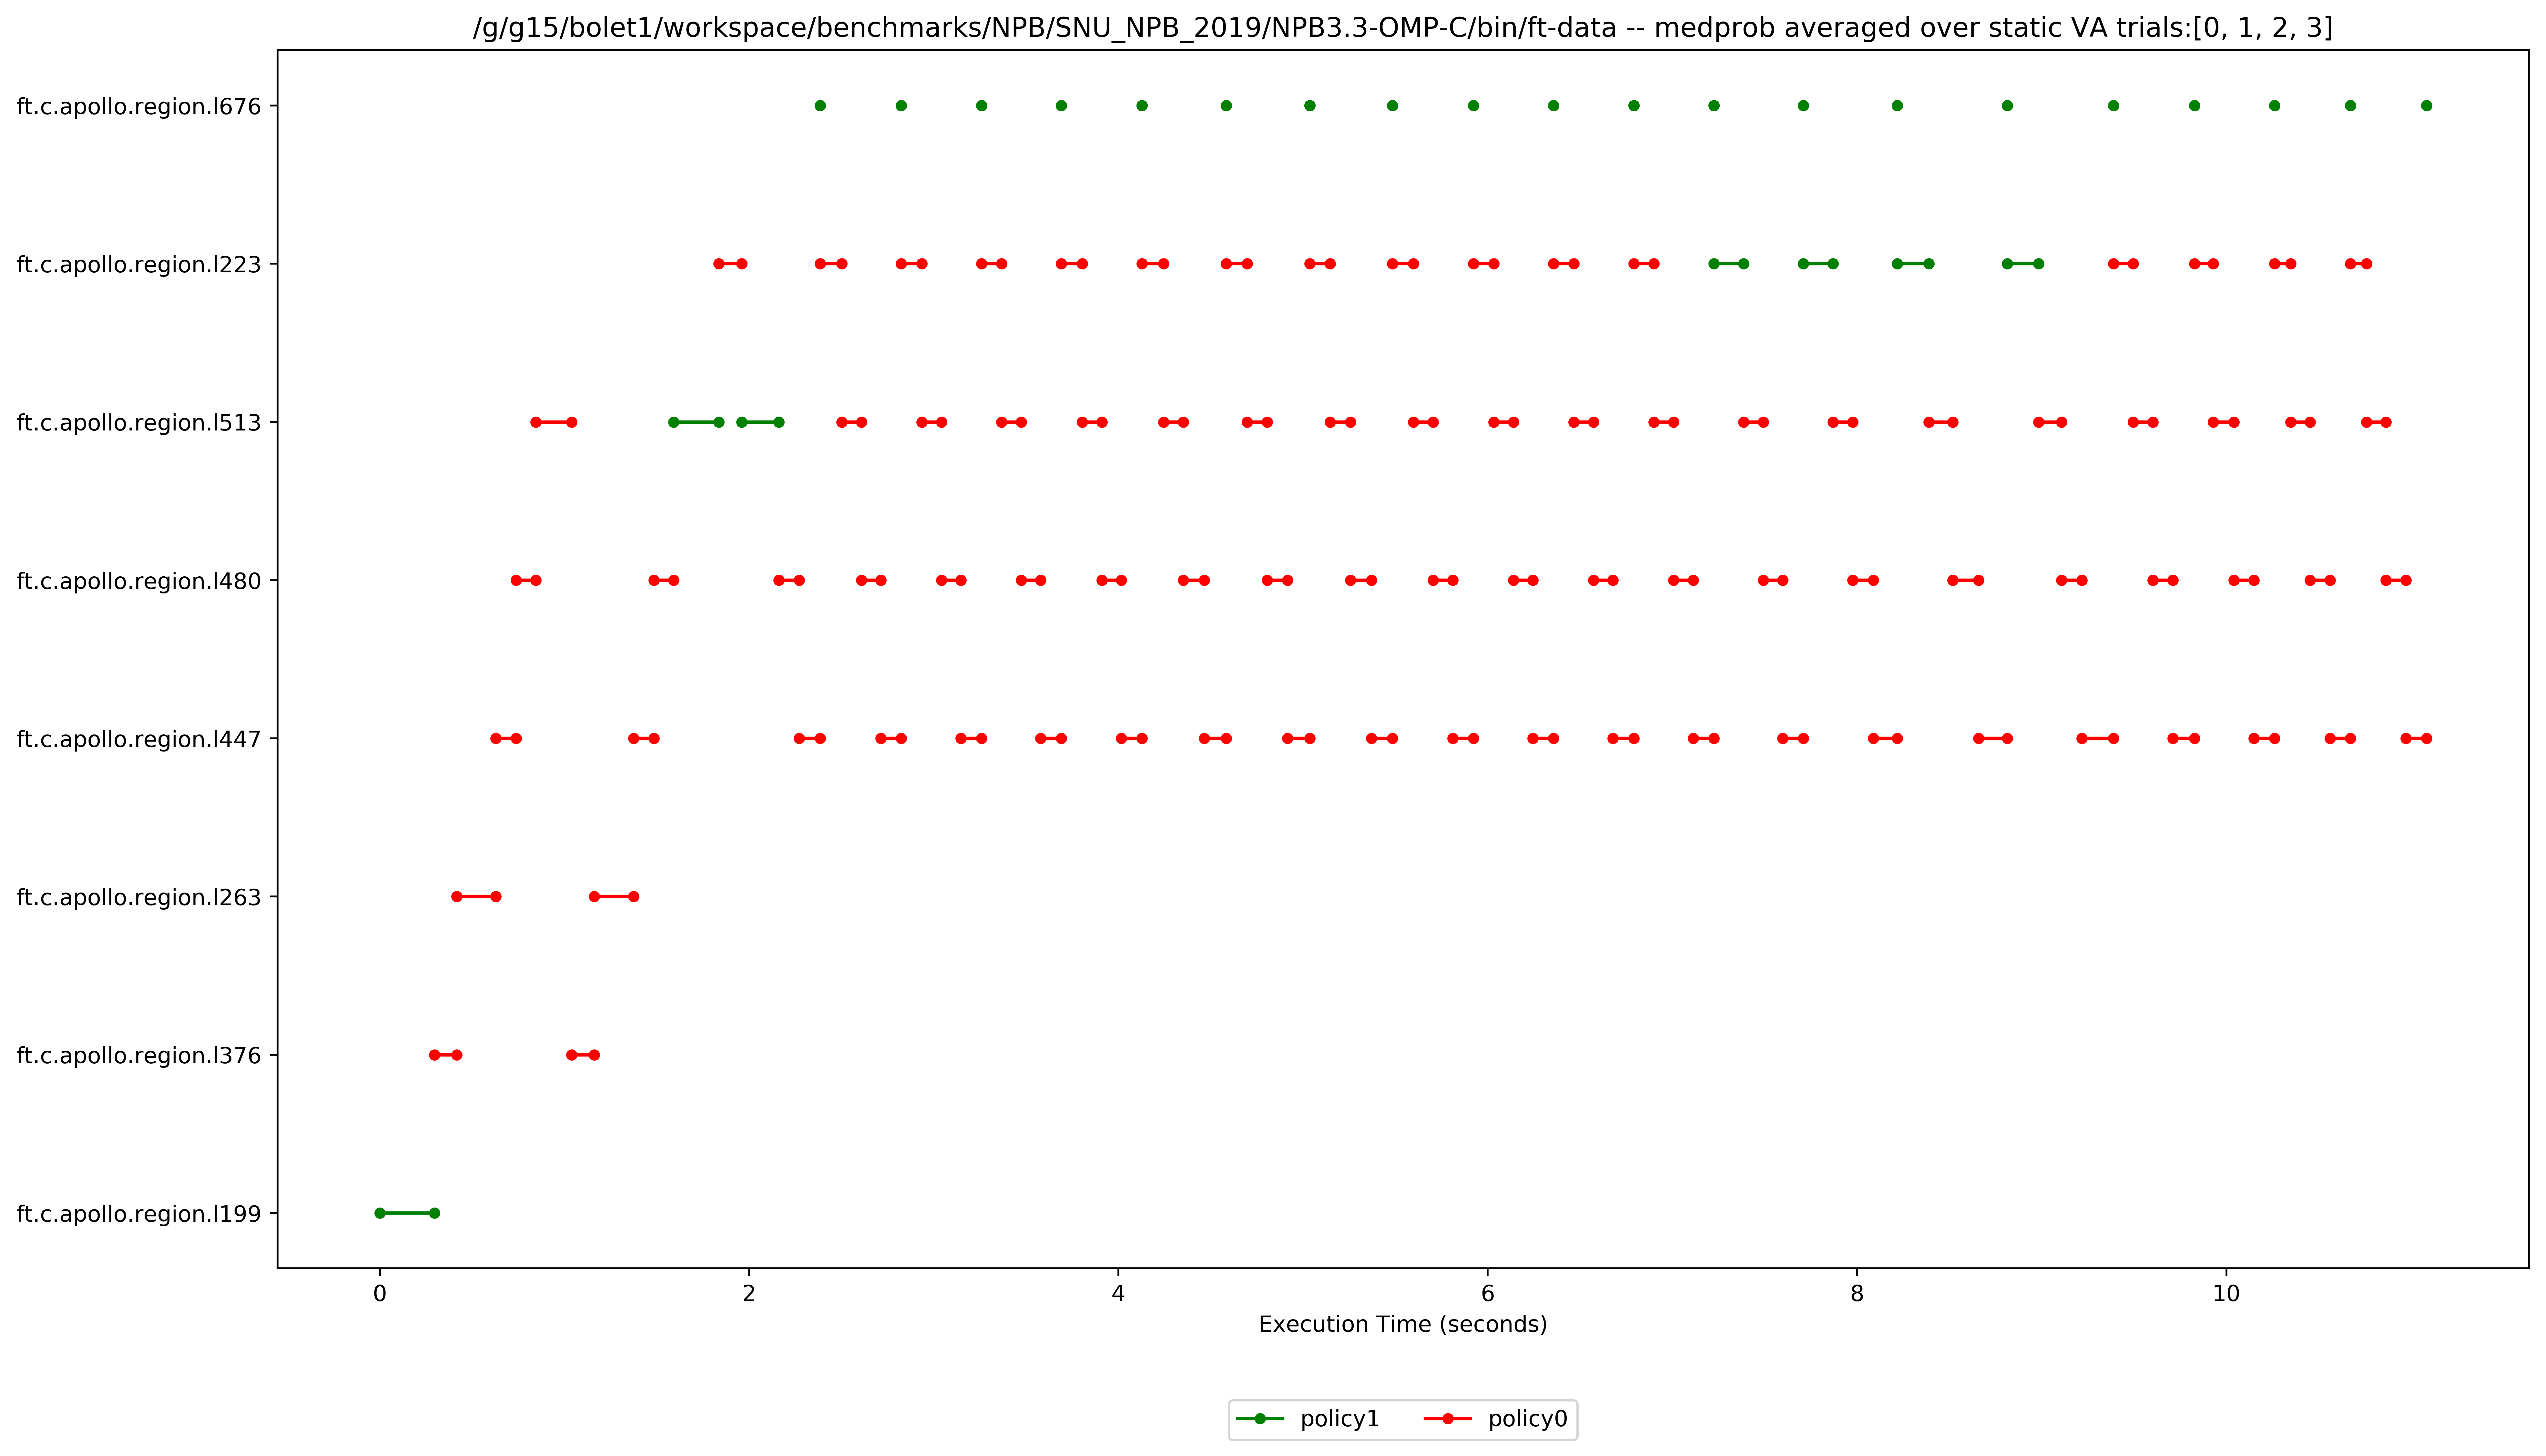

CPU times: user 6.6 s, sys: 110 ms, total: 6.71 s
Wall time: 6.66 s


In [44]:
%%time
plotOptimalPolicy(df, policiesToPlot=[0,1,2])

current index:  0 ( 0.006249609399412537 )
current index:  1000 ( 6.2558590088119495 )
current index:  2000 ( 12.505468408224486 )
current index:  3000 ( 18.755077807637022 )
current index:  4000 ( 25.00468720704956 )
current index:  5000 ( 31.254296606462095 )
current index:  6000 ( 37.50390600587463 )
current index:  7000 ( 43.75351540528717 )
current index:  8000 ( 50.00312480469971 )
current index:  9000 ( 56.252734204112244 )
current index:  10000 ( 62.50234360352478 )
current index:  11000 ( 68.75195300293731 )
current index:  12000 ( 75.00156240234985 )
current index:  13000 ( 81.2511718017624 )
current index:  14000 ( 87.50078120117493 )
current index:  15000 ( 93.75039060058747 )
current index:  16000 ( 100.0 )
dict_keys(['euler3d_cpu.cpp.apollo.region.l119', 'euler3d_cpu.cpp.apollo.region.l77', 'euler3d_cpu.cpp.apollo.region.l174', 'euler3d_cpu.cpp.apollo.region.l211', 'euler3d_cpu.cpp.apollo.region.l347'])


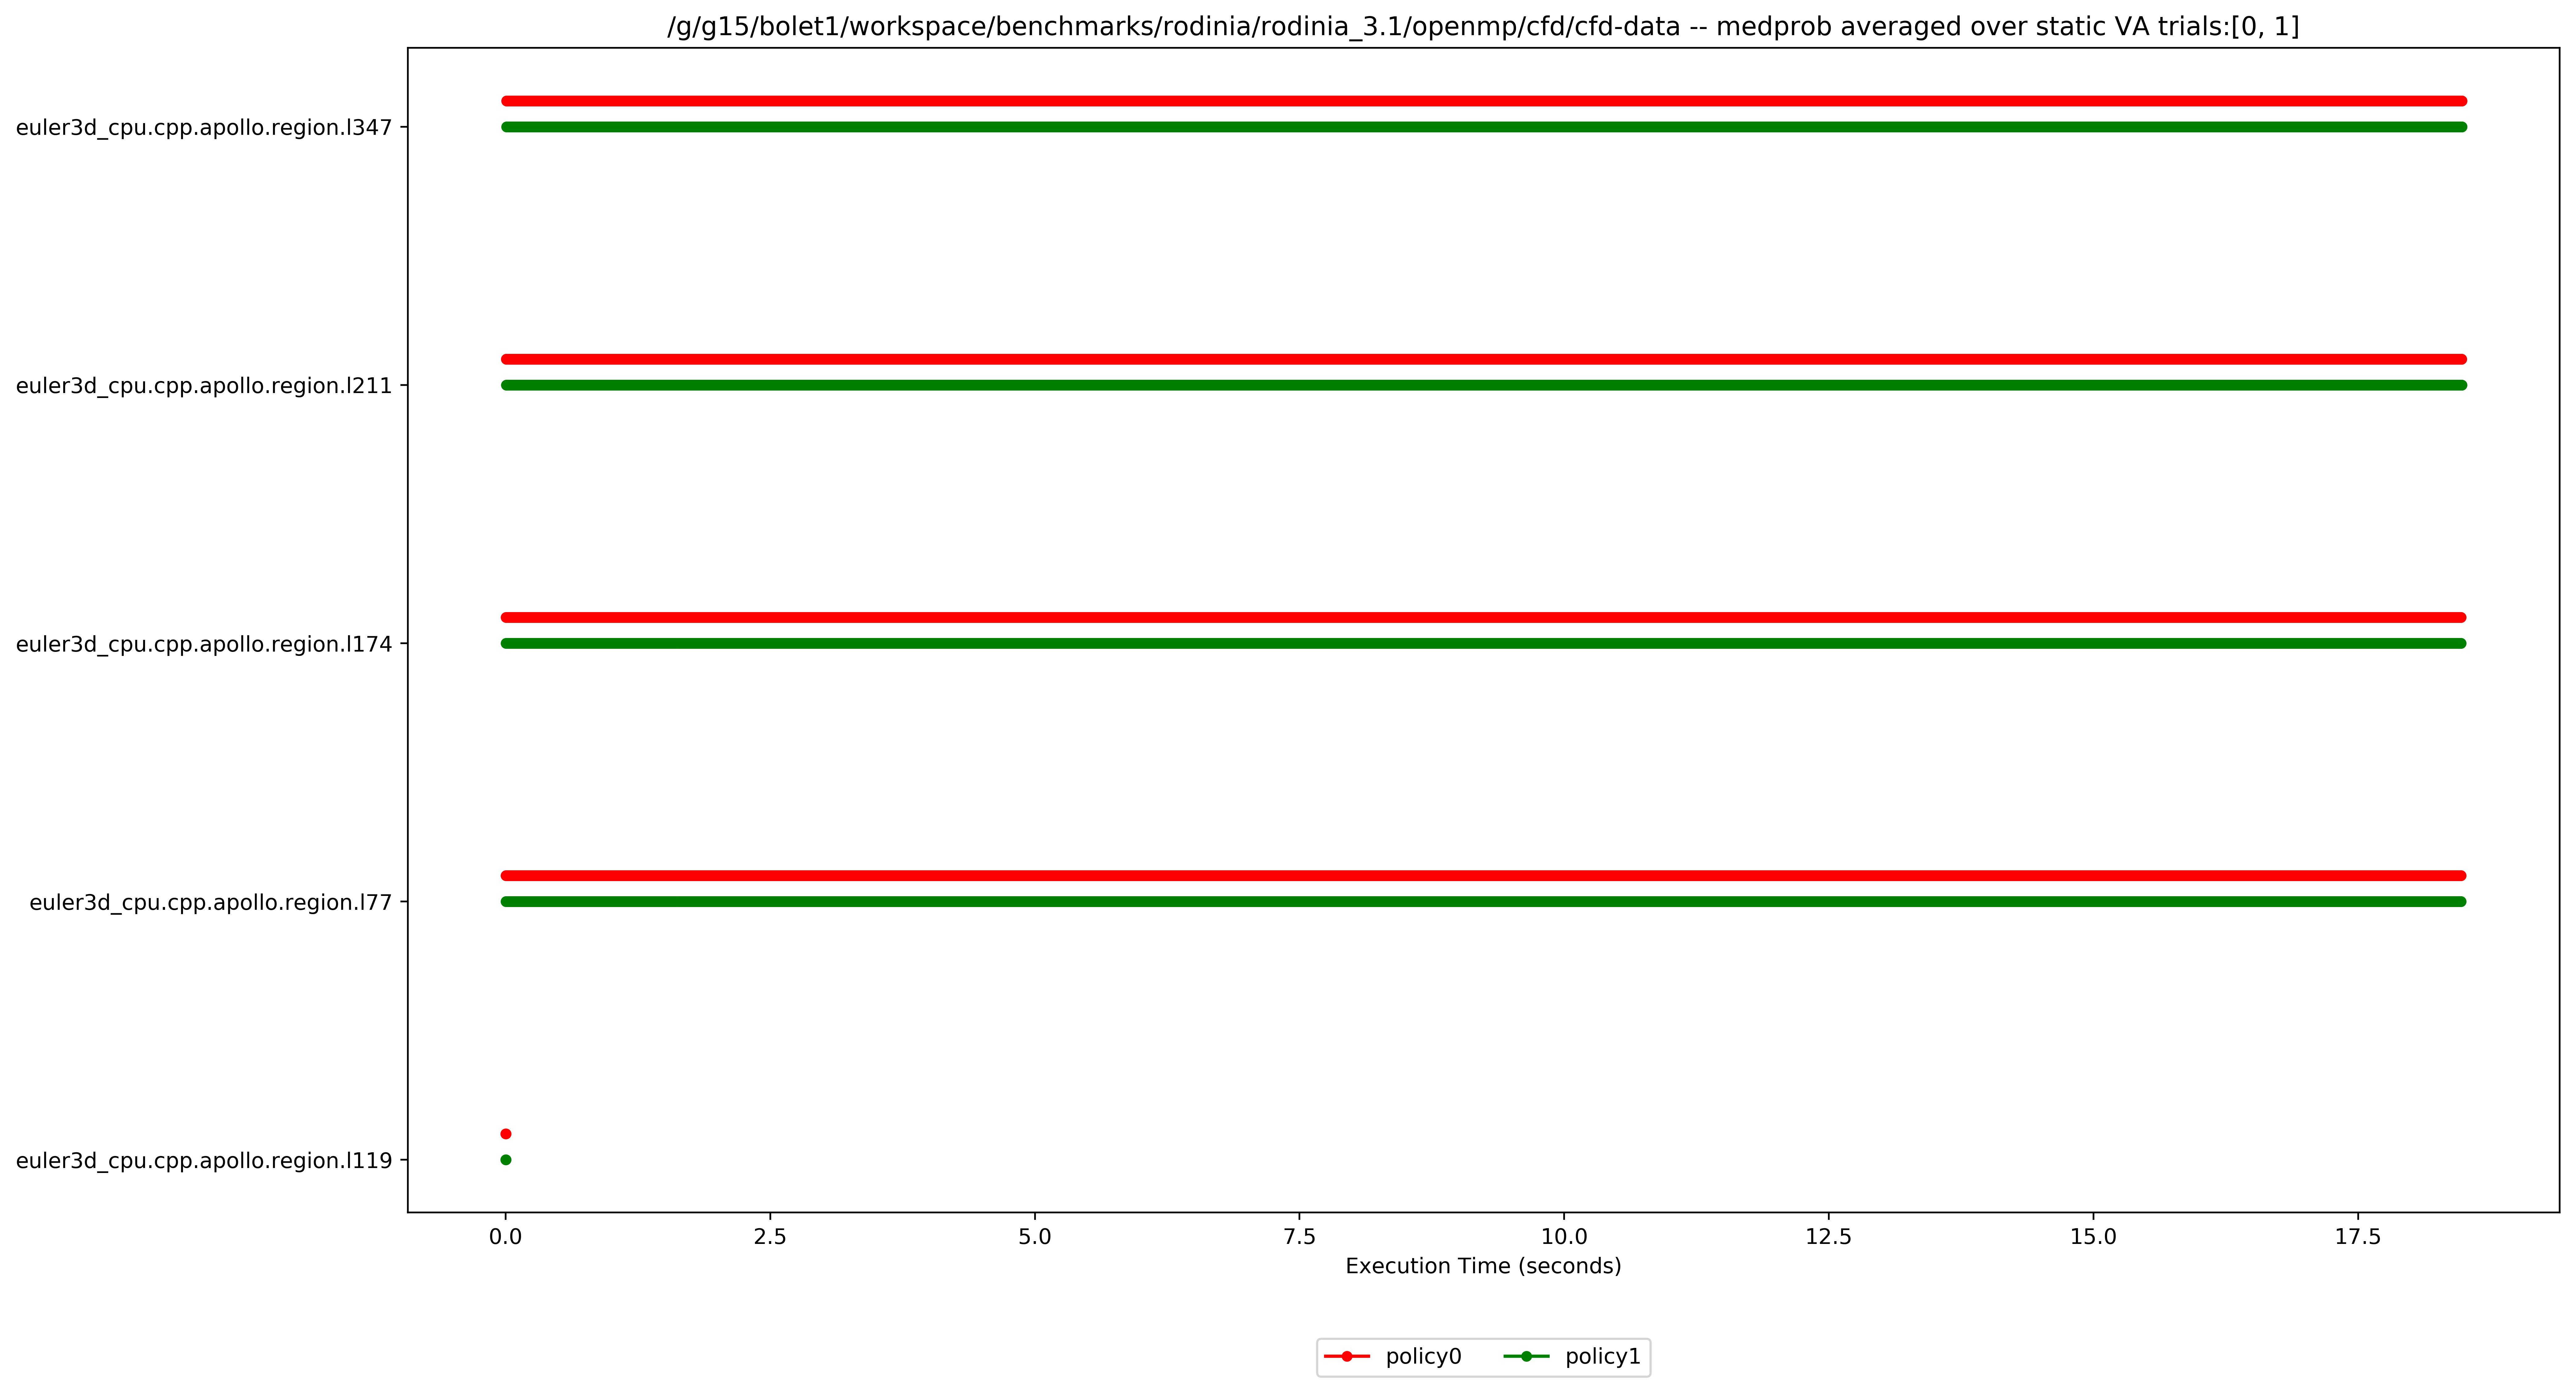

current index:  0 ( 0.006249609399412537 )
current index:  1000 ( 6.2558590088119495 )
current index:  2000 ( 12.505468408224486 )
current index:  3000 ( 18.755077807637022 )
current index:  4000 ( 25.00468720704956 )
current index:  5000 ( 31.254296606462095 )
current index:  6000 ( 37.50390600587463 )
current index:  7000 ( 43.75351540528717 )
current index:  8000 ( 50.00312480469971 )
current index:  9000 ( 56.252734204112244 )
current index:  10000 ( 62.50234360352478 )
current index:  11000 ( 68.75195300293731 )
current index:  12000 ( 75.00156240234985 )
current index:  13000 ( 81.2511718017624 )
current index:  14000 ( 87.50078120117493 )
current index:  15000 ( 93.75039060058747 )


In [ ]:
%%time
plotAllPolicies(df, policiesToPlot=[0,1])
plotAllPolicies(df, policiesToPlot=[0,1,2])